In [24]:
# !pip install ipywidgets

In [1]:
!pip install -U tensorly
!pip install -U tensorly-torch

In [1]:
import tltorch
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

/opt/conda/lib/python3.8/site-packages/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

In [4]:
def get_cifar100_transform(train=True):
    if train:
        transform = T.Compose([
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761), inplace=True)

        ])

    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

    return transform

In [5]:
batch_size = 128

train_set = CIFAR100('CIFAR100', train=True, download=True,
                    transform=get_cifar100_transform(train=True))
test_set = CIFAR100('CIFAR100', train=False, download=True,
                   transform=get_cifar100_transform(train=False))
train_loader = DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def plot_losses_epoch(loss, accuracy, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')
    axs[0][0].set_xlabel('epoch')
    axs[0][0].legend()

    axs[0][1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[0][1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[0][1].set_ylabel('accuracy')
    axs[0][1].set_xlabel('epoch')
    axs[0][1].legend()

    axs[1][0].plot(range(1, len(loss) + 1), loss)
    axs[1][0].set_ylabel('loss')
    axs[1][0].set_xlabel('batch')

    axs[1][1].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1][1].set_ylabel('accuracy')
    axs[1][1].set_xlabel('batch')

    for r_ax in axs:
        for ax in r_ax:
            ax.grid()

    plt.show()

In [7]:
def save_checkpoint(epoch, model, optimizer, train_loss, test_loss, test_accuracy, train_accuracy, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss' : test_loss,
            'test_accuracy' : test_accuracy,
            'train_accuracy' : train_accuracy
            }, path)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [10]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:3", desc='Training...', train_losses=[], test_losses=[], train_accuracies=[], test_accuracies=[]):
    model.to(device)
    model.train()

    losses = []
    accuracies = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    batch_num = 0

    for images, labels in tqdm(train_dataloader, desc=desc):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))
        accuracies += [(logits.argmax(dim=-1).to('cpu') == labels.to('cpu')).double().mean().item()]
        
        if batch_num % 50 == 0:
            plot_losses_epoch(losses, accuracies, train_losses, test_losses, train_accuracies, test_accuracies)
        batch_num += 1
        
    return losses, predicted_classes.tolist(), true_classes.tolist()


def predict(model, val_dataloader, criterion, device="cuda:3", desc='Evaluating...'):
    model.to(device)
    model.eval()

    val_losses = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    for images, labels in tqdm(val_dataloader, desc=desc):

        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        val_losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))

    return val_losses, predicted_classes.tolist(), true_classes.tolist()

In [14]:
from torch.optim.lr_scheduler import MultiStepLR

start_epoch = 0
RESUME = False
criterion = nn.CrossEntropyLoss()


if RESUME:
    start_epoch, model, optimizer, train_losses, test_losses = load_checkpoint('models/linear' + f'-epoch{start_epoch}.pt')

In [15]:
def train():
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(start_epoch + 1, n_epochs + 1):
        train_losses_epoch, train_predicted_classes, train_true_classes = train_one_epoch(model, train_loader, criterion, optimizer, device, f'Training {epoch}/{n_epochs}', train_losses, test_losses, train_accuracies, test_accuracies)
        train_losses += [sum(train_losses_epoch) / len(train_losses_epoch)]
        train_accuracies += [(torch.Tensor(train_predicted_classes) == torch.Tensor(train_true_classes)).type(torch.DoubleTensor).mean().item()]
        
        scheduler.step(epoch)

        test_losses_epoch, test_predicted_classes, test_true_classes = predict(model, test_loader, criterion, device, f'Evaluating... {epoch}/{n_epochs}')
        test_losses += [sum(test_losses_epoch) / len(test_losses_epoch)]
        test_accuracies += [(torch.Tensor(test_predicted_classes) == torch.Tensor(test_true_classes)).type(torch.DoubleTensor).mean().item()]

        if epoch % save_epoch == 0 and epoch > 0:
            save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, train_loss=train_losses, \
                test_loss=test_losses, test_accuracy=test_accuracies, train_accuracy=train_accuracies, \
                path= save_path + f'-epoch{epoch}.pt')
    return train_losses, test_losses, train_accuracies, test_accuracies

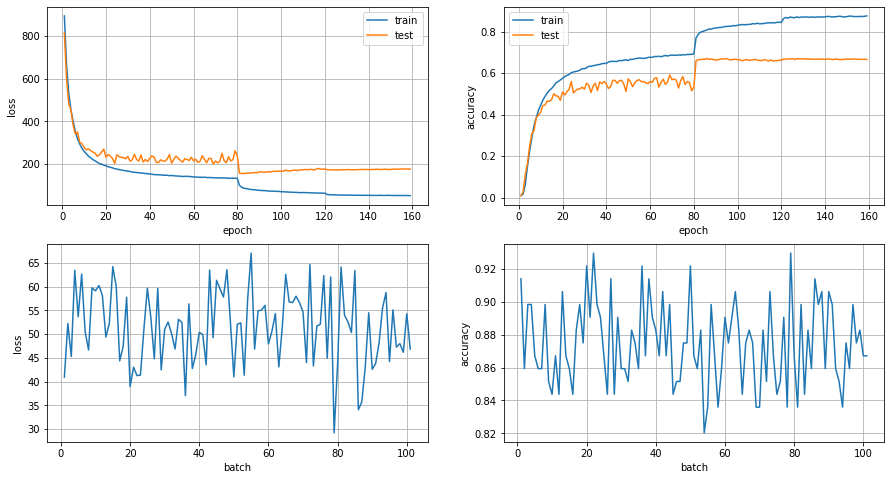

In [ ]:
n_epochs = 180
save_epoch = 20
model = resnet20().to(device)
save_path = 'models/linear'

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4, momentum=0.9)

milestones = [80, 120]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
cur_train_losses, cur_test_losses, cur_train_accuracies, cur_test_accuracies = train()